In [131]:
import zarr
from pyprojroot import here
import pandas as pd
import numpy as np
import allel
import yaml
import matplotlib.pyplot as plt
import functools
import seaborn as sns
sns.set_context('paper')
import dask.array as da
import scipy.interpolate
import scipy.stats
import petl as etl
import pyfasta
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
genome_path = here() / 'agam-selection-atlas-build/data/external/vectorbase/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa'
genome = pyfasta.Fasta(str(genome_path), key_fn=lambda x: x.split()[0])
genome

In [86]:
chromosomes = '2', '3', 'X'
chromosome_plen = {
    '2': len(genome['2R']) + len(genome['2L']), 
    '3': len(genome['3R']) + len(genome['3L']), 
    'X': len(genome['X'])
}

In [12]:
pop_defs_path = here() / 'agam-selection-atlas-build/gwss/pop_defs.yml'
with open(pop_defs_path, 'rt') as f:
    pop_defs = yaml.safe_load(f)
pops = list(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [15]:
h12_root_path = here() / 'agam-selection-atlas-build/data/gwss/h12/h12.zarr'
h12_root = zarr.open_consolidated(str(h12_root_path))

    
def load_h12_gwss(pop, chromosome):
    window_size = pop_defs[pop]['h12_window_size']
    window_step = 200
    grp = h12_root[f'{pop}/{window_size}/{window_step}/{chromosome}']
    return (
        grp['windows'][:],
        grp['gwindows'][:],
        grp['h1'][:],
        grp['h12'][:],
        grp['h123'][:],
        grp['h2_h1'][:]
    )

In [146]:
def plot_h12(pop, chromosome, ax=None, markersize=.5):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Reds", 4)[1:]
    windows, gwindows, h1, h12, h123, h2_h1 = load_h12_gwss(pop, chromosome)
    x = windows.mean(axis=1) / 1e6
    ax.plot(x, h123, linestyle=' ', marker='o', color=palette[0], markersize=markersize, label='H123')
    ax.plot(x, h12, linestyle=' ', marker='o', color=palette[1], markersize=markersize, label='H12')
    ax.plot(x, h1, linestyle=' ', marker='o', color=palette[2], markersize=markersize, label='H1')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_lengths[chromosome] / 1e6)
    ax.set_ylim(0, 1)
    

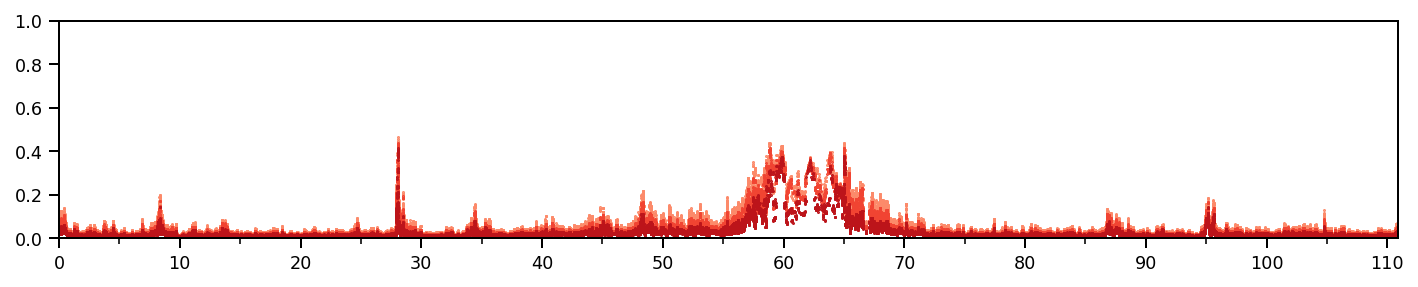

In [147]:
plot_h12('ao_col', '2')

In [124]:
ihs_root_path = here() / 'agam-selection-atlas-build/data/gwss/ihs/ihs.zarr'
ihs_root = zarr.open_consolidated(str(ihs_root_path))


@functools.lru_cache(maxsize=None)
def load_ihs_gwss(pop, chromosome, window_size=200, window_step=100):
    grp = ihs_root[f'{pop}/{chromosome}']
    pos = grp['pos'][:]
    ihs_std = np.fabs(grp['ihs_std'][:])
    x = allel.moving_statistic(pos, np.mean, size=window_size, step=window_step)
    y_max = allel.moving_statistic(ihs_std, np.max, size=window_size, step=window_step)
    y_pc95 = allel.moving_statistic(ihs_std, lambda v: np.percentile(v, 95), size=window_size, step=window_step)
    y_pc75 = allel.moving_statistic(ihs_std, lambda v: np.percentile(v, 75), size=window_size, step=window_step)
    y_pc50 = allel.moving_statistic(ihs_std, np.median, size=window_size, step=window_step)
    return x, y_max, y_pc95, y_pc75, y_pc50


In [225]:
def plot_ihs(pop, chromosome, ax=None, markersize=.5, window_size=200, window_step=100):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Blues", 5)[1:]
    x, y_max, y_pc95, y_pc75, y_pc50 = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
    x = x/1e6
    ax.plot(x, y_max.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[0], label='max')
    ax.plot(x, y_pc95.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[1], label='pc95')
    ax.plot(x, y_pc75.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[2], label='pc75')
    ax.plot(x, y_pc50.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[3], label='pc50')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_lengths[chromosome] / 1e6)
    ax.set_ylim(0, 10)
    

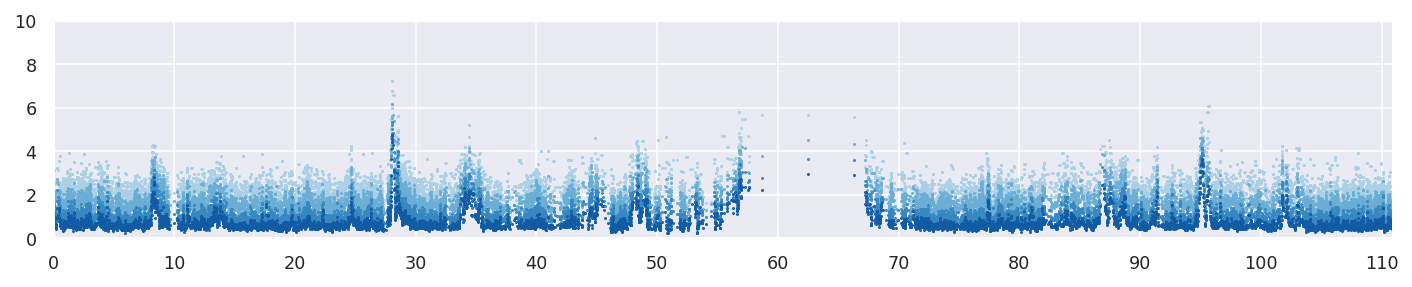

In [226]:
plot_ihs('ao_col', '2')

In [163]:
xpehh_root_path = here() / 'agam-selection-atlas-build/data/gwss/xpehh/xpehh.zarr'
xpehh_root = zarr.open_consolidated(str(xpehh_root_path))


@functools.lru_cache(maxsize=None)
def load_xpehh_gwss(pop1, pop2, chromosome, window_size=500, window_step=250):

    # avoid running the same scan twice
    orig_pop1, orig_pop2 = pop1, pop2
    pop1, pop2 = sorted([pop1, pop2])
    
    grp = xpehh_root[f'{pop1}_{pop2}/{chromosome}']
    pos = grp['pos'][:]
    xpehh = grp['xpehh'][:]

    if pop1 == orig_pop2:
        # flip back
        xpehh = -xpehh
        pop1, pop2 = pop2, pop1

    # centre
    xpehh = xpehh - np.median(xpehh)
    
    # clip at zero to focus on selection in pop1
    xpehh1 = np.clip(xpehh, a_min=0, a_max=None)
    
    x = allel.moving_statistic(pos, np.mean, size=window_size, step=window_step)
    y_max = allel.moving_statistic(xpehh1, np.max, size=window_size, step=window_step)
    y_pc95 = allel.moving_statistic(xpehh1, lambda v: np.percentile(v, 95), size=window_size, step=window_step)
    y_pc75 = allel.moving_statistic(xpehh1, lambda v: np.percentile(v, 75), size=window_size, step=window_step)
    y_pc50 = allel.moving_statistic(xpehh1, np.median, size=window_size, step=window_step)
    
    return x, y_max, y_pc95, y_pc75, y_pc50


In [223]:
def plot_xpehh(pop1, pop2, chromosome, ax=None, markersize=.5, window_size=500, window_step=250):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Greens", 5)[1:]
    x, y_max, y_pc95, y_pc75, y_pc50 = load_xpehh_gwss(pop1, pop2, chromosome, window_size=window_size, window_step=window_step)
    x = x/1e6
    ax.plot(x, y_max.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[0], label='max')
    ax.plot(x, y_pc95.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[1], label='pc95')
    ax.plot(x, y_pc75.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[2], label='pc75')
    ax.plot(x, y_pc50.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[3], label='pc50')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_lengths[chromosome] / 1e6)
    ax.set_ylim(0, 6)
    

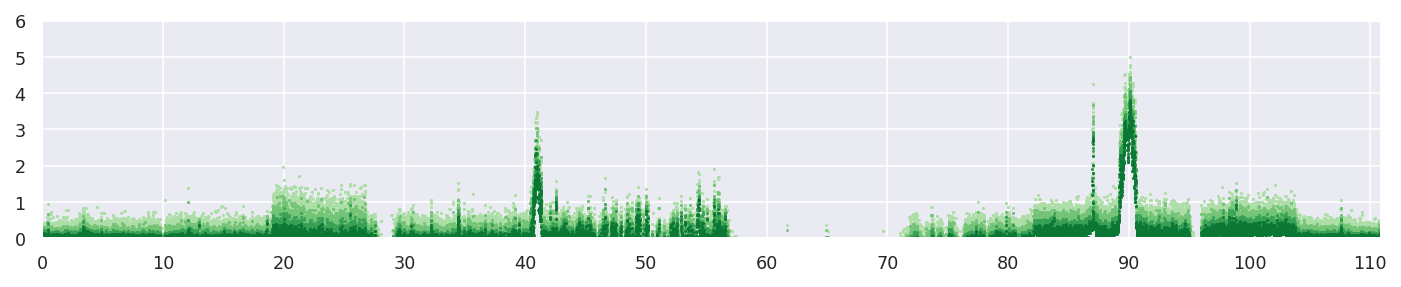

In [224]:
plot_xpehh('bf_gam', 'ug_gam', '2')

In [230]:
pbs_root_path = here() / 'agam-selection-atlas-build/data/gwss/pbs/pbs.zarr'
pbs_root = zarr.open_consolidated(str(pbs_root_path))


@functools.lru_cache(maxsize=None)
def load_pbs_gwss(pop1, pop2, pop3, chromosome, window_size=500, window_step=250):

    grp_path = f'/{pop1}_{pop2}_{pop3}/{window_size}/{window_step}/{chromosome}'
    grp = pbs_root[grp_path]
    windows = grp['windows'][:]
    gwindows = grp['gwindows'][:]
    pbs = grp['pbs'][:]
    pbs_scaled = grp['pbs_scaled'][:]
    
    return windows, gwindows, pbs, pbs_scaled


In [238]:
def plot_pbs(pop1, pop2, pop3, chromosome, ax=None, markersize=.5, window_size=500, window_step=250):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Greens", 5)[1:]
    windows, gwindows, pbs, pbs_scaled = load_pbs_gwss(
        pop1, pop2, pop3, chromosome, window_size=window_size, window_step=window_step
    )
    x = windows.mean(axis=1)/1e6
    palette = sns.color_palette()
    ax.plot(x, pbs_scaled.clip(0, 50), marker='o', linestyle=' ', markersize=markersize, 
            color=palette[4])
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_lengths[chromosome] / 1e6)
    ax.set_ylim(0, 50)
    

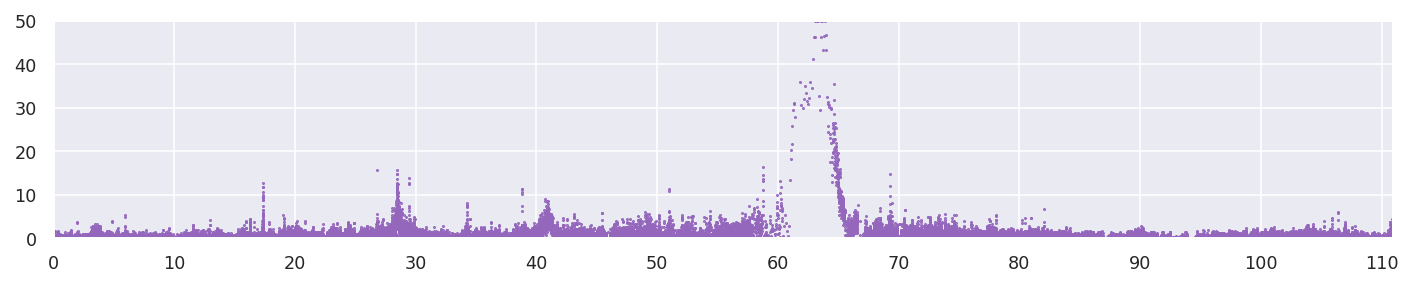

In [241]:
plot_pbs('bf_gam', 'ug_gam', 'gq_gam', '2')

In [273]:
def fig_gwss(pop, xpehh_pop, pbs_pops, markersize=.5, figsize=(12, 7), savefig=None, savefig_dpi=150):
    
    fig = plt.figure(figsize=figsize, facecolor='w')
    width_ratios = [chromosome_lengths[c] for c in chromosomes]
    gs = fig.add_gridspec(ncols=3, nrows=4, width_ratios=width_ratios)
    
    # H12
    
    ax = fig.add_subplot(gs[0, 0])
    sns.despine(ax=ax, offset=3)
    plot_h12(pop, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$H12$')
    ax.set_xticklabels([])
    ax.set_title('Chromosome 2')

    ax = fig.add_subplot(gs[0, 1])
    sns.despine(ax=ax, offset=3, left=True)
    plot_h12(pop, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    ax.set_title('Chromosome 3')

    ax = fig.add_subplot(gs[0, 2])
    sns.despine(ax=ax, offset=3, left=True)
    plot_h12(pop, chromosome='X', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    ax.set_title('Chromosome X')
    
    # iHS
    
    ax = fig.add_subplot(gs[1, 0])
    sns.despine(ax=ax, offset=3)
    plot_ihs(pop, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$|iHS|$')
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[1, 1])
    sns.despine(ax=ax, offset=3, left=True)
    plot_ihs(pop, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    ax = fig.add_subplot(gs[1, 2])
    sns.despine(ax=ax, offset=3, left=True)
    plot_ihs(pop, chromosome='X', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    # XPEHH

    ax = fig.add_subplot(gs[2, 0])
    sns.despine(ax=ax, offset=3)
    plot_xpehh(pop, xpehh_pop, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$XP-EHH$')
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[2, 1])
    sns.despine(ax=ax, offset=3, left=True)
    plot_xpehh(pop, xpehh_pop, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    ax = fig.add_subplot(gs[2, 2])
    sns.despine(ax=ax, offset=3, left=True)
    plot_xpehh(pop, xpehh_pop, chromosome='X', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    # PBS
    pop2, pop3 = pbs_pops

    ax = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax, offset=3)
    plot_pbs(pop, pop2, pop3, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$PBS$')
    ax.set_xlabel(f'Position (Mbp)')
    
    ax = fig.add_subplot(gs[3, 1])
    sns.despine(ax=ax, offset=3, left=True)
    plot_pbs(pop, pop2, pop3, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xlabel(f'Position (Mbp)')
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    ax = fig.add_subplot(gs[3, 2])
    sns.despine(ax=ax, offset=3, left=True)
    plot_pbs(pop, pop2, pop3, chromosome='X', ax=ax, markersize=markersize)
    ax.set_xlabel(f'Position (Mbp)')
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    pop_label = (
        pop_defs[pop]["label"]
        .replace('An. gambiae', '$An. gambiae$')
        .replace('An. coluzzii', '$An. coluzzii$')
    )
    fig.suptitle(pop_label)
    fig.tight_layout()
    
    if savefig:
        fig.savefig(savefig, bbox_inches='tight', dpi=savefig_dpi)


In [274]:
sns.set_style('darkgrid')

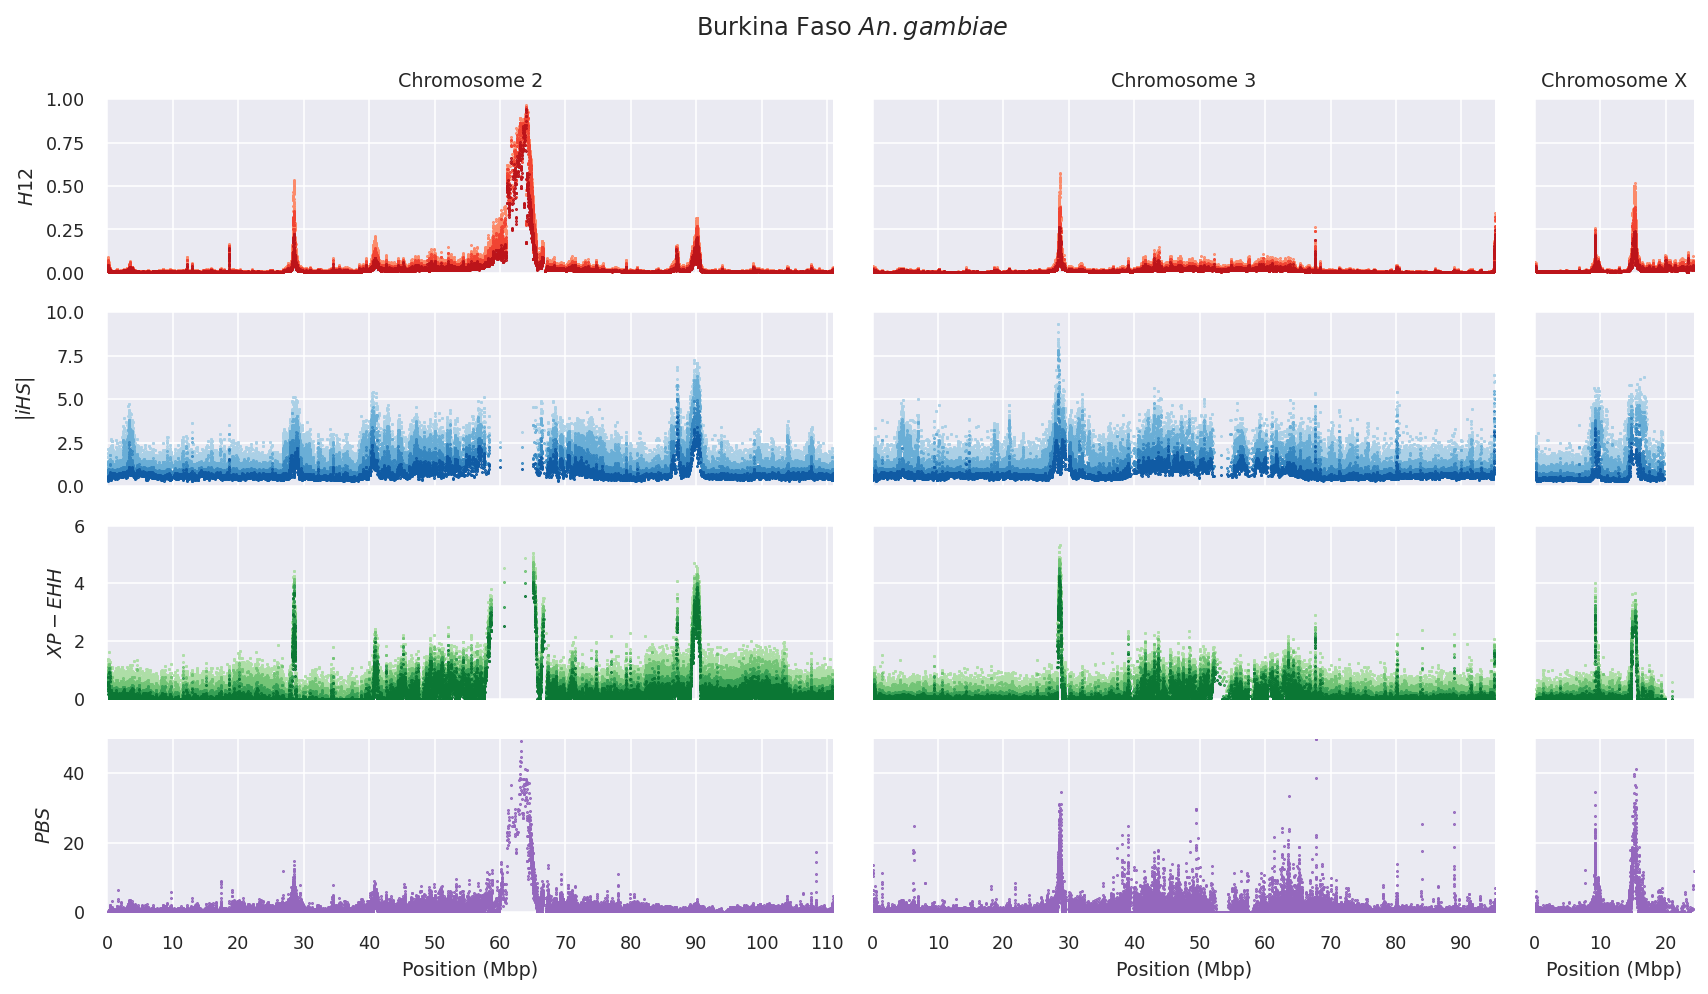

In [275]:
fig_gwss('bf_gam', xpehh_pop='gw', pbs_pops=('ug_gam', 'gw'),
         savefig=here() / 'artwork/gwss_bf_gam.png')

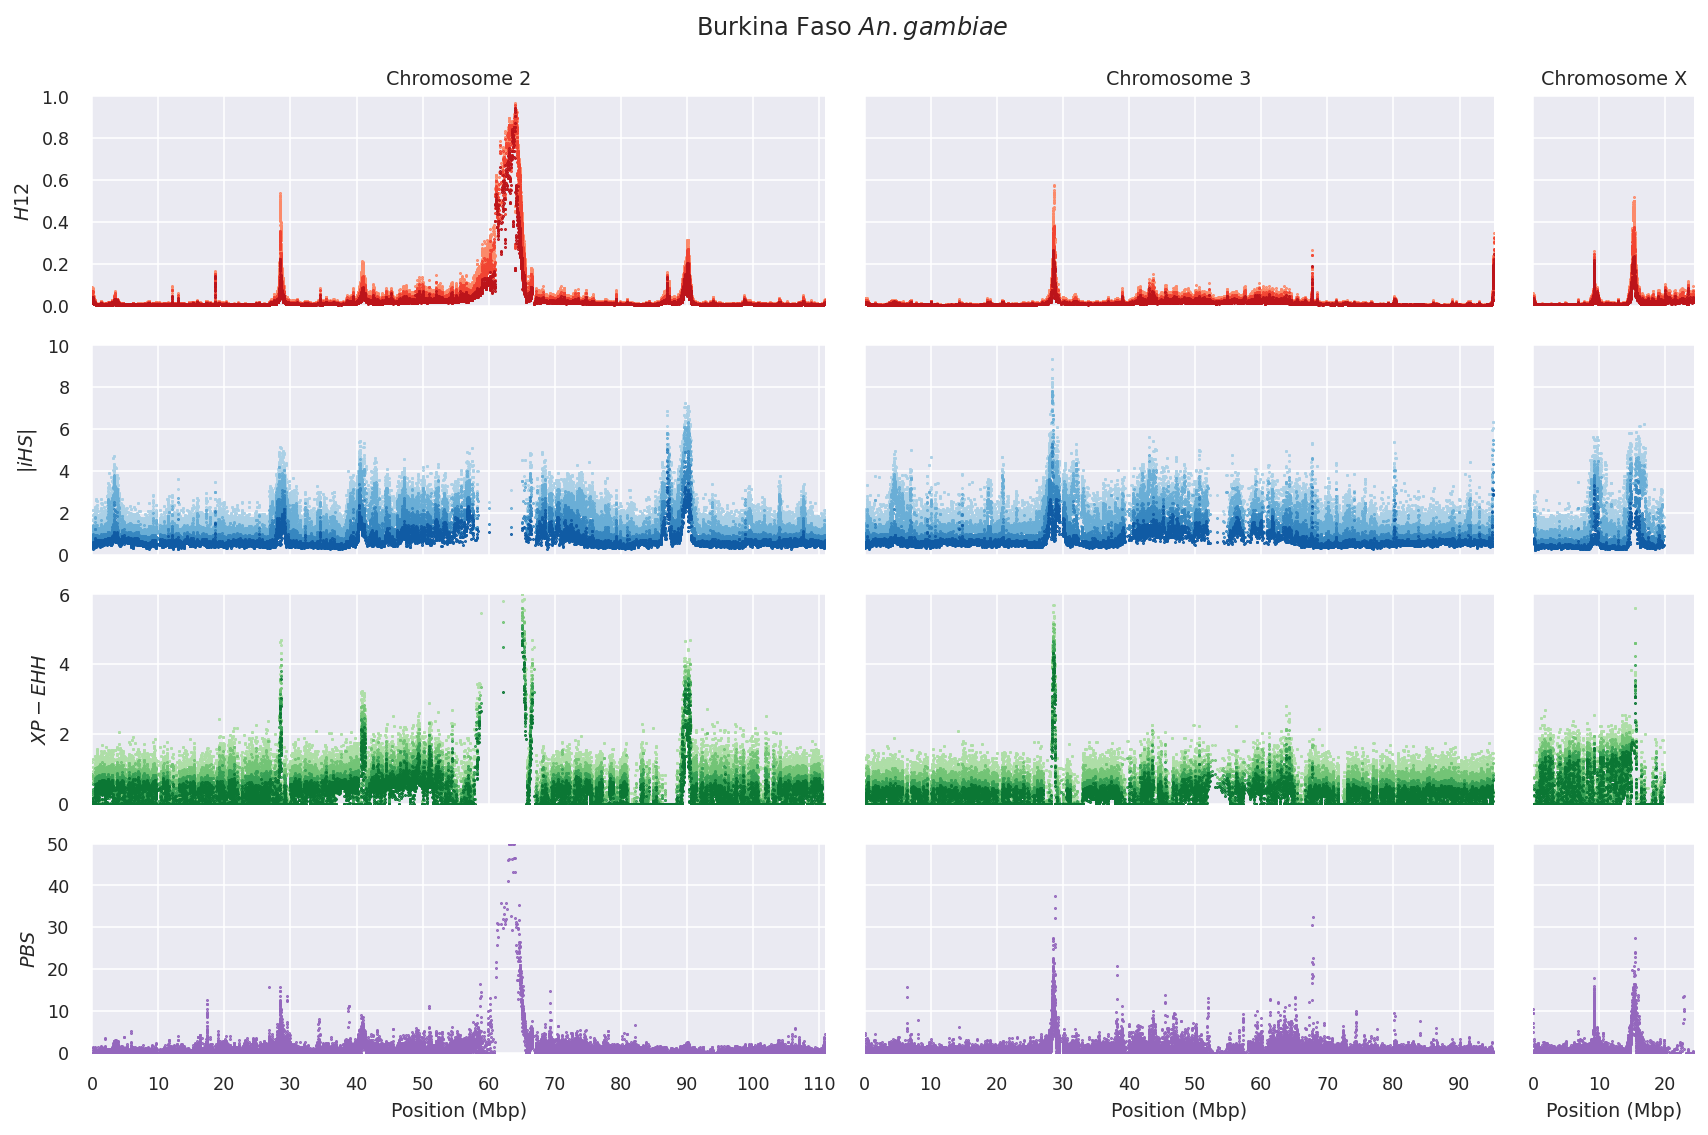

In [259]:
fig_gwss('bf_gam', xpehh_pop='gq_gam', pbs_pops=('ug_gam', 'gq_gam'))